# Numerical Optimization

Zhentao Shi

<!-- code is tested on SCRP -->

In [1]:
library(magrittr)

## Optimization 

* Econometrics curriculum does not pay enough attention to numerical optimization
* Most estimators solve optimization

* Operational research
* Understand the essence

### User Cases

* Maximum likelihood estimation
* Discrete / mixed data type
* Machine learning / regularization
* Classification

* Big data stochastic algorithm


* Generic optimization problem

$$
\min_{\theta \in \Theta } f(\theta) \,\, \mathrm{ s.t. }  g(\theta) = 0, h(\theta) \leq 0,
$$

* $f(\cdot)\in \mathbb{R}$: criterion function
* $g(\theta) = 0$: a vector of equality constraints
* $h(\theta)\leq 0$: a vector of inequality constraints.


* unconstrained
* constrained
* Lagrangian 

### Convenience vs. Efficiency

* Convenience: readability of the mathematical expressions and the code
* Efficiency:  computing speed

* Put convenience as priority at the trial-and-error stage, 
* Improve efficiency when necessary at a later stage for full-scale execution.

## Methods

* Many optimization algorithms
* Variants of a few fundamental principles.


## Newton's Method

* Essential idea for optimizing a twice-differentiable objective function
* Necessary condition: the first-order condition

$$
s(\theta) = \partial f(\theta) / \partial \theta = 0
$$

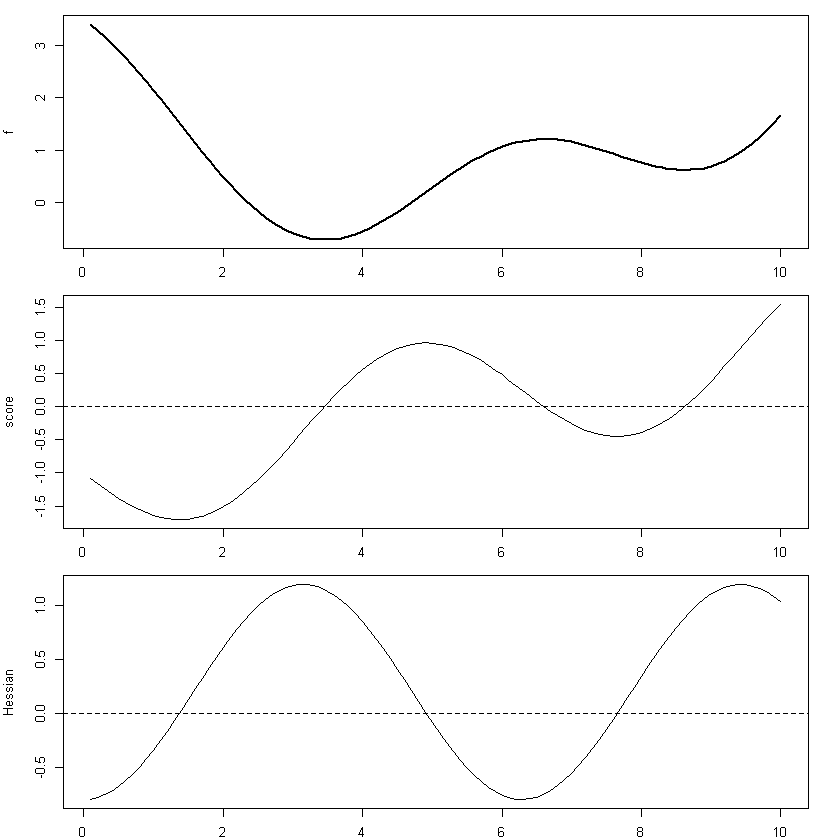

In [2]:
f <- function(x) 0.1 * (x - 5)^2 + cos(x) # criterion
s <- function(x) 0.2 * (x - 5) - sin(x) # gradient
h <- function(x) 0.2 - cos(x) # Hessian

# plot
par(mfrow = c(3, 1))
par(mar = c(2, 4, 1, 2))

x_base <- seq(0.1, 10, by = 0.1)
plot(y = f(x_base), x = x_base, type = "l", lwd = 2, ylab = "f")
plot(y = s(x_base), x = x_base, type = "l", ylab = "score")
abline(h = 0, lty = 2)
plot(y = h(x_base), x = x_base, type = "l", ylab = "Hessian")
abline(h = 0, lty = 2)

### Iteartion

* Initial trial value $\theta_0$, 
* If $s(\theta_0) \neq 0$, updated by

$$
\theta_{t+1} = \theta_{t} -  \left( H(\theta_t)  \right)^{-1}  s(\theta_t)
$$

for the index of iteration $t=0,1,\cdots$
* $H(\theta) = \frac{ \partial s(\theta )}{ \partial \theta}$ is the Hessian. 


### Mechanism

* Taylor expansion
at $\theta_t$ round  $\theta_{\star}$, a root of $s(\cdot)$. Because $\theta_{ \star }$  is a root,

$$
0 = s(\theta_{\star}) = s(\theta_t) + H(\theta_t) (\theta_{t+1} - \theta_t) + O( (\theta_{t+1} - \theta_t)^2 ).
$$



### Update

* Ignore the high-order term and rearrange,

$$
\theta_{\star} = \theta_{t} -  \left( H(\theta_t)  \right)^{-1}  s(\theta_t)
$$ 

* iteration formula by replacing $\theta_{\star}$ with the updated $\theta_{t+1}$. 
* Iterate until $|\theta_{t+1} -\theta_{t}| < \epsilon$ (absolute criterion) and/or
$|\theta_{t+1} -\theta_{t}|/|\theta_{t}| < \epsilon$ (relative criterion), 
* $\epsilon$ is a small positive number chosen as a tolerance level.


In [3]:
# Newton's method
Newton <- function(x) {
  x - s(x) / h(x)
} # update formula

In [4]:
x_init <- 6 # can experiment with various initial values

gap <- 1
epsilon <- 0.0001 # tolerance
while (gap > epsilon) {
  x_new <- Newton(x_init) %>% print()
  gap <- abs(x_init - x_new)
  x_init <- x_new
}

[1] 6.630669
[1] 6.611217
[1] 6.611302


## Features of Newton's Method


* It seeks the solution to $s(\theta) = 0$. 
* The first-order condition is necessary but not sufficient
* Verify the second-order condition
* Compare the value of multiple minima for global minimum

* It requires gradient $s(\theta)$ and the Hessian $H(\theta)$.
* It numerically converges at quadratic rate.

## Quasi-Newton Method

* Most well-known quasi-Newton algorithm is [BFGS](http://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)
* It avoids explicit calculation of Hessian
* It starts from an initial (inverse) Hessian
* Updates Hessian by an explicit formula via quadratic approximation

## Derivative-Free Method

* [Nelder-Mead](http://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)
* Simplex method
* Search a local minimum 
  * reflection
  * expansion
  * contraction



## Package

* [R Optimization Task View](http://cran.r-project.org/web/views/Optimization.html) 
* Package [`optimx`](http://cran.r-project.org/web/packages/optimx/index.html) ([Nash, 2014](https://www.jstatsoft.org/article/view/v060i02))
  * Unified interface for various widely-used algorithms. 
  * Facilitates comparison among optimization algorithms
  

### Example

* Use `optimx` to solve pseudo Poisson maximum likelihood estimation (PPML)
* Popular estimator for cross-country bilateral trade
* Conditional mean model

$$
E[y_i | x_i] = \exp( x_i' \beta),
$$

### Poisson MLE

If $Z \sim Poisson(\lambda)$, then 

$$
\Pr(Z = k) = \frac{\mathrm{e}^{-\lambda} \lambda^k}{k!}, \mathrm{ for }\, \, k=0,1,2,\ldots,
$$

and the log-likelihood

$$
\log \Pr(Y = y | x) =  -\exp(x'\beta) + y\cdot x'\beta - \log k!
$$

* Log-likelihood function of the sample

$$
\ell(\beta) = \log \Pr( \mathbf{y} | \mathbf{x};\beta ) =
-\sum_{i=1}^n \exp(x_i'\beta) + \sum_{i=1}^n y_i x_i'\beta.
$$

* gradient

$$
s(\beta) =\frac{\partial \ell(\beta)}{\partial \beta} =
-\sum_{i=1}^n \exp(x_i'\beta)x_i + \sum_{i=1}^n y_i x_i.
$$

* Hessian

$$
H(\beta) = \frac{\partial^2 \ell(\beta)}{\partial \beta \partial \beta'} =
-\sum_{i=1}^n \exp(x_i'\beta)x_i x_i'
$$

is negative definite.

* $\ell(\beta)$ is strictly concave in $\beta$.

* Default optimization is minimization
* Use *negative* log-likelihood


In [5]:
# Poisson likelihood
poisson.loglik <- function(b) {
  b <- as.matrix(b)
  lambda <- exp(X %*% b)
  ell <- -sum(-lambda + y * log(lambda))
  return(ell)
}

* Write the criterion as a function of the parameter to be optimized 
* Data can be fed inside or outside of the function.
  * If the data is provided as additional arguments, these arguments must be explicit.


In [6]:
# implement both BFGS and Nelder-Mead for comparison.

library(AER)

## prepare the data
data("RecreationDemand")
y <- RecreationDemand$trips
X <- with(RecreationDemand, cbind(1, income))

## estimation
b.init <- c(0, 1) # initial value
b.hat <- optimx::optimx(b.init, poisson.loglik,
  method = c("BFGS", "Nelder-Mead"),
  control = list(
    reltol = 1e-7,
    abstol = 1e-7
  )
)
print(b.hat)


Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



                  p1          p2    value fevals gevals niter convcode  kkt1
BFGS        1.177411 -0.09994234 261.1141     99     21    NA        0  TRUE
Nelder-Mead 1.167261 -0.09703975 261.1317     53     NA    NA        0 FALSE
            kkt2 xtime
BFGS        TRUE  0.04
Nelder-Mead TRUE  0.02


### Alternative Formulation

* Nonlinear least squares (NLS) is also valid in theory.
* NLS minimizes

$$
\sum_{i=1}^n (y_i - \exp(x_i \beta))^2
$$

* Why PPML is preferred? 

* PPML's optimization for the linear index is globally convex.
* Numerical optimization of PPML is easier and more robust

### Caveats

* No algorithm suits all problems. 
* Simulation is helpful to check the accuracy of optimization
* Contour plot helps visualize the function surface/manifold

### Example

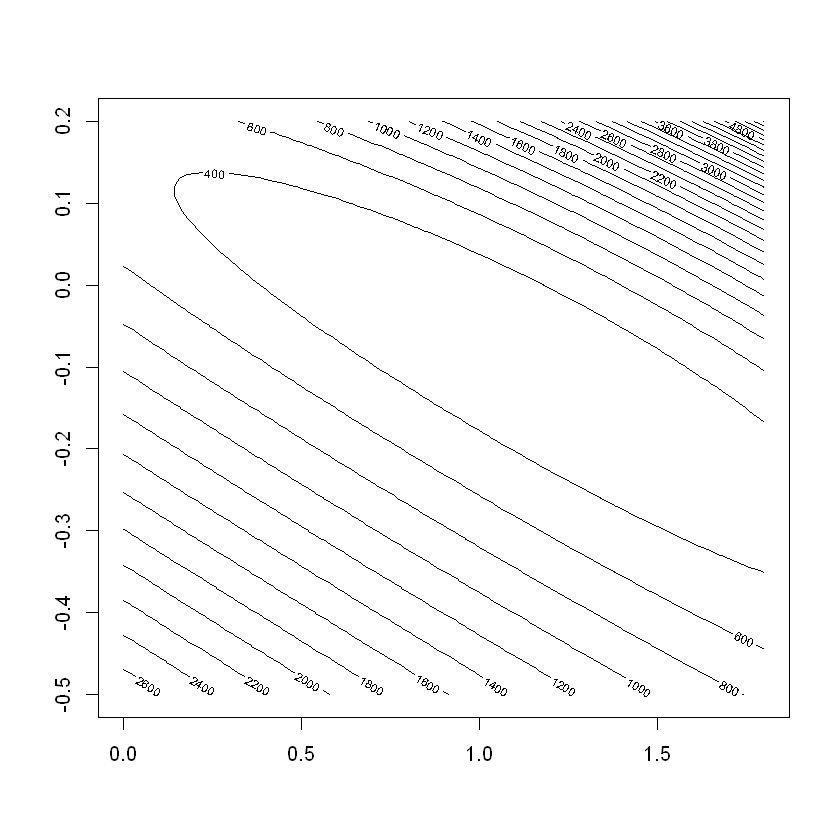

In [7]:
x.grid <- seq(0, 1.8, 0.02)
x.length <- length(x.grid)
y.grid <- seq(-.5, .2, 0.01)
y.length <- length(y.grid)

z.contour <- matrix(0, nrow = x.length, ncol = y.length)

for (i in 1:x.length) {
  for (j in 1:y.length) {
    z.contour[i, j] <- poisson.loglik(c(x.grid[i], y.grid[j]))
  }
}

contour(x.grid, y.grid, z.contour, 20)

### NLOPT

* Third-party standalone solvers 
* [`NLopt`](http://ab-initio.mit.edu/wiki/index.php/NLopt_Installation)
* [extensive list of algorithms](http://ab-initio.mit.edu/wiki/index.php/NLopt_Algorithms#SLSQP)
* Package [`nloptr`](http://cran.r-project.org/web/packages/nloptr/index.html)


### Example

We first carry out the Nelder-Mead algorithm in NLOPT.


In [8]:
## optimization with NLoptr

opts <- list(
  "algorithm" = "NLOPT_LN_NELDERMEAD",
  "xtol_rel" = 1.0e-7,
  maxeval = 500
)

res_NM <- nloptr::nloptr(
  x0 = b.init,
  eval_f = poisson.loglik,
  opts = opts
)
print(res_NM)

# "SLSQP" is indeed the BFGS algorithm in NLopt,
# though "BFGS" doesn't appear in the name
opts <- list("algorithm" = "NLOPT_LD_SLSQP", "xtol_rel" = 1.0e-7)


Call:
nloptr::nloptr(x0 = b.init, eval_f = poisson.loglik, opts = opts)


Minimization using NLopt version 2.7.1 

NLopt solver status: 4 ( NLOPT_XTOL_REACHED: Optimization stopped because 
xtol_rel or xtol_abs (above) was reached. )

Number of Iterations....: 114 
Termination conditions:  xtol_rel: 1e-07	maxeval: 500 
Number of inequality constraints:  0 
Number of equality constraints:    0 
Optimal value of objective function:  261.114078295329 
Optimal value of controls: 1.177397 -0.09993984




To invoke BFGS in NLOPT, we must code up the gradient $s(\beta)$,
as in the function `poisson.log.grad()`.

In [9]:
poisson.loglik.grad <- function(b) {
  b <- as.matrix(b)
  lambda <- exp(X %*% b)
  ell <- -colSums(-as.vector(lambda) * X + y * X)
  return(ell)
}


* Compare the analytical gradient with the numerical gradient
* Ensure the code is correct.

In [10]:
# check the numerical gradient and the analytical gradient
b <- c(0, .5)
numDeriv::grad(poisson.loglik, b)
poisson.loglik.grad(b)

[1]  6542.46 45825.40

income 
 6542.46 45825.40

BFGS with Gradient

In [11]:
res_BFGS <- nloptr::nloptr(
  x0 = b.init,
  eval_f = poisson.loglik,
  eval_grad_f = poisson.loglik.grad,
  opts = opts
)
print(res_BFGS)


Call:

nloptr::nloptr(x0 = b.init, eval_f = poisson.loglik, eval_grad_f = poisson.loglik.grad, 
    opts = opts)


Minimization using NLopt version 2.7.1 

NLopt solver status: 4 ( NLOPT_XTOL_REACHED: Optimization stopped because 
xtol_rel or xtol_abs (above) was reached. )

Number of Iterations....: 41 
Termination conditions:  xtol_rel: 1e-07 
Number of inequality constraints:  0 
Number of equality constraints:    0 
Optimal value of objective function:  261.114078295329 
Optimal value of controls: 1.177397 -0.09993984




## Convex Optimization

* Local minimum is a global minimum.
* Particularly important in high-dimensional problems
* [Boyd and Vandenberghe (2004)](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)
* "Convex optimization is technology; all other optimizations are arts."

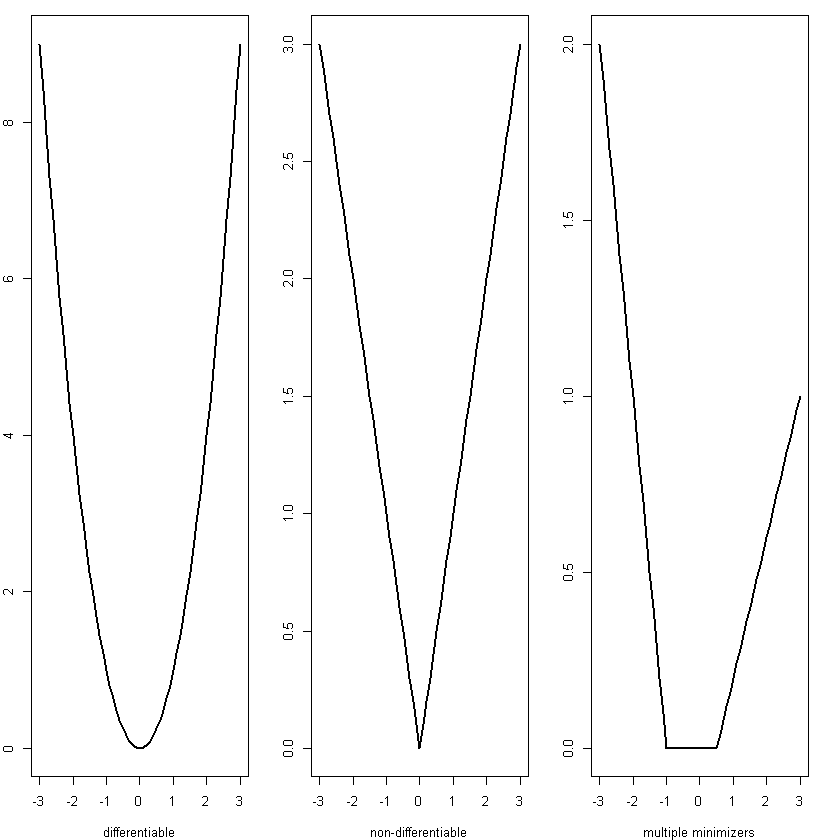

In [12]:
f1 <- function(x) x^2
f2 <- function(x) abs(x)
f3 <- function(x) (-x - 1) * (x <= -1) + (0.4 * x - .2) * (x >= .5)

par(mfrow = c(1, 3))
par(mar = c(4, 2, 1, 2))

x_base <- seq(-3, 3, by = 0.1)
plot(y = f1(x_base), x = x_base, type = "l", lwd = 2, xlab = "differentiable")
plot(y = f2(x_base), x = x_base, type = "l", lwd = 2, xlab = "non-differentiable")
plot(y = f3(x_base), x = x_base, type = "l", lwd = 2, xlab = "multiple minimizers")


### Example

* Linear regression model MLE


* Normal MLE. The (negative) log-likelihood 

$$
\ell (\beta, \sigma) = \log \sigma + \frac{1}{2\sigma^2}\sum_{i=1}^n (y_i - x_i' \beta)^2
$$

is not convex

* Re-parameterize the criterion function by $\gamma = 1/\sigma$ and $\alpha = \beta / \sigma$, then

$$
\ell (\alpha, \gamma) = -\log \gamma + \frac{1}{2}
\sum_{i=1}^n (\gamma y_i - x_i' \alpha)^2
$$

is convex in $\alpha, \gamma$

* Many MLE estimators in econometric textbooks are convex. 

* [Gao and Shi (2021)](https://link.springer.com/article/10.1007/s10614-020-09995-z) explore the infrastructure in R for convex optimization with two econometric examples. 

* `CVXR` [(Fu, 2018)](https://arxiv.org/abs/1711.07582) is a convenient convex modeling language 
  * Proprietary solvers `CLEPX`, `MOSEK`, and `Gurubi`
  * Open-source solvers `ECOS` and `SDPT3`. 

* `MOSEK` offers free academic license
* [`Rmosek`](http://rmosek.r-forge.r-project.org/)

### Example: Relaxed empirical likelihood

Consider a model with a "true" parameter $\beta_0$ satisfying the moment condition $\mathrm{E}\left[  h\left(Z_i, \beta_0 \right)\right] = 0_m$, where $\left\{Z_i \right\}_{i=1}^n$ is the observed data, $\beta$
is a low dimensional parameter of interest, and  $h$ is an $\mathbb{R}^{m}$-valued moment function. 
Empirical likelihood (EL) [[Owen, 1988]](https://www.jstor.org/stable/2336172) [[Qin, 1994]](https://scholar.google.com/scholar_url?url=https://projecteuclid.org/journals/annals-of-statistics/volume-22/issue-1/Empirical-Likelihood-and-General-Estimating-Equations/10.1214/aos/1176325370.pdf&hl=zh-CN&sa=X&ei=jjrrY-iRBueR6rQP_p6hkAQ&scisig=AAGBfm1LBkrfAAtQfwCPvp4R62ge0YKx4A&oi=scholarr) solves

$$
\max_{\beta \in \mathcal{B}, \pi \Delta_n} \; \sum_{i=1}^n \log \pi_i \;\,\, \text{s.t.} \; \sum_{i=1}^n \pi_i h \left( Z_i, \beta \right) = 0_m
$$

where $\Delta_{n} = \left\{ \pi\in\left[0,1\right]^{n}:\sum_{i=1}^{n}\pi_{i}=1 \right\}$ is the $n$-dimensional probability simplex.



To handle the high-dimensional case, i.e., $m > n$, [[Shi, 2016]](https://www.sciencedirect.com/science/article/abs/pii/S0304407616301373) proposes the relaxed empirical likelihood (REL),  defined as the solution to 

$$
\max_{\beta\in\mathcal{B}}\max_{\pi\in\Delta_{n}^{\lambda}\left(\beta\right)}\,\sum_{i=1}^{n}\log\pi_{i}
$$

where 

$$
\Delta_{n}^{\lambda}\left(\beta\right)=\left\{ \pi_i \in\Delta_{n}:\big|\sum_{i=1}^{n}\pi_{i}h_{ij}\left(\beta\right)\big|\leq\lambda,\:j=1,2,\cdots,m\right\}
$$

is a relaxed simplex, $\lambda\geq0$ is a tuning parameter, $h_{ij}\left(\beta\right)=h_{j}\left(Z_{i},\beta\right)$
is the $j$-th component of $h\left(Z_{i},\beta\right)$.

Similar to standard EL, REL's optimization involves an inner loop
and an outer loop. The outer loop for $\beta$ is a general low-dimensional
nonlinear optimization, which can be solved by Newton-type methods.
With the linear constraints and the logarithm objective, the inner
loop is convex in $\pi=\left(\pi_{i}\right)_{i=1}^{n}$. 
By introducing auxiliary variable, $t_i$, the logarithm objective can be formulated as a linear objective function $\sum_{i=1}^n t_i$ and $n$ exponential conic constraints, $\left(\pi_{i}, 1, t_{i}\right) \in \mathcal{K}_{\mathrm{exp}}=\left\{\left(x_{1}, x_{2}, x_{3}\right): x_{1} \geq x_{2} \exp \left(x_{3} / x_{2}\right), x_{2}>0\right\} \cup\left\{\left(x_{1}, 0, x_{3}\right): x_{1} \geq 0, x_{3} \leq 0\right\}$, $i=1,2,\cdots,n$. 




For each $\beta$, the inner problem can be then formulated as a conic programming problem,

$$
\begin{aligned}
&\max _{\pi, t} \sum_{i=1}^{n} t_{i}\\
\text { s.t. }&\left[\begin{array}{c}
1 \\
-\lambda \\
\vdots \\
-\lambda
\end{array}\right] \leq\left[\begin{array}{cccc}
1 & 1 & \cdots & 1 \\
h_{11}(\beta) & h_{21}(\beta) & \cdots & h_{n 1}(\beta) \\
\vdots & \vdots & \ddots & \vdots \\
h_{1 m}(\beta) & h_{2 m}(\beta) & \cdots & h_{n m}(\beta)
\end{array}\right]\left[\begin{array}{c}
\pi_{1} \\
\pi_{2} \\
\vdots \\
\pi_{n}
\end{array}\right] \leq\left[\begin{array}{c}
1 \\
\lambda \\
\vdots \\
\lambda
\end{array}\right]\\
&\left(\pi_{i}, 1, t_{i}\right) \in \mathcal{K}_{\mathrm{exp}}, 0 \leq \pi_{i} \leq 1, \text { for each } i=1,2, \cdots, n
\end{aligned}
$$

To understand the exponential cone, notice that 
$\left(\pi_{i}, 1, t_{i}\right) \in \mathcal{K}_{\mathrm{exp}}$ is equivalent to
$\{ \pi_i \geq \exp(t_i): \pi_i\geq 0, t_i \leq 0 \}$. It implies 
$t_i \leq \log \pi_i$. Since the problem maximizes $\sum t_i$, we must have 
$t_i = \log \pi_i$. 
The constrained optimization is readily solvable in `Rmosek` by translating the mathematical expression into computer code.


In [13]:
innerloop <- function(b, y, X, Z, tau) {
  n <- nrow(Z)
  m <- ncol(Z)

  # Generate moment condition
  H <- MomentMatrix(y, X, Z, b)

  # Initialize the mosek problem
  Prob <- list(sense = "max")

  # Prob$dparam$intpnt_nl_tol_rel_gap <- 1e-5;
  Prob$dparam <- list(INTPNT_CO_TOL_REL_GAP = 1e-5)

  # Linear coefficients of the objective
  Prob$c <- c(rep(0, n), rep(1, n), rep(0, n))

  # Linear constraints
  H_tilde <- Matrix(rbind(rep(1, n), H), sparse = TRUE)
  A <-
    rbind(
      cbind(H_tilde, Matrix(0, m + 1, 2 * n, sparse = TRUE)),
      cbind(Matrix(0, n, 2 * n, sparse = TRUE), Diagonal(n))
    )
  Prob$A <- A
  Prob$bc <-
    rbind(c(1, rep(-tau, m), rep(1, n)), c(1, rep(tau, m), rep(1, n)))
  Prob$bx <- rbind(
    c(rep(0, n), rep(-Inf, n), rep(1, n)),
    c(rep(1, n), rep(0, n), rep(1, n))
  )

  # Exponential Cones
  NUMCONES <- n
  Prob$cones <- matrix(list(), nrow = 2, ncol = NUMCONES)
  rownames(Prob$cones) <- c("type", "sub")
  for (i in 1:n) {
    Prob$cones[, i] <- list("PEXP", c(i, 2 * n + i, n + i))
  }

  # Invoke Mosek
  mosek.out <- mosek(Prob, opts = list(verbose = 0, soldetail = 1))

  if (mosek.out$sol$itr$solsta == "OPTIMAL") {
    # Since the default of NLOPTR is to do minimization, need to set it as negative
    return(-mosek.out$sol$itr$pobjval)
  } else {
    warning("WARNING: Inner loop not optimized")
    return(Inf)
  }
}


The inner loop optimization can also be carried out by `CVXR`.
This code snippet is shorter than easier to read.

In [14]:
innerloop.cvxr <- function(b, y = NULL, X = NULL, Z = NULL, tau = NULL) {
  n <- nrow(Z)
  m <- ncol(Z)

  H <- MomentMatrix(y, X, Z, b)

  p <- Variable(n)
  constr <- list(
    sum(p) == 1,
    p >= 0,
    p <= 1,
    H %*% p >= -tau,
    H %*% p <= tau
  )

  obj <- sum(log(p))
  obj <- Maximize(obj)

  Prob <- Problem(obj, constr)
  cvxr.out <- solve(Prob)

  if (cvxr.out$status == "optimal") {
    return(-cvxr.out$value)
  } else {
    warning("WARNING: Inner loop not optimized")
    return(Inf)
  }
}
